<a href="https://colab.research.google.com/github/juyeon-shin/CLUB-D.N.A./blob/main/2022/01.%20%ED%8E%AD%EA%B7%84%20%EB%AA%B8%EB%AC%B4%EA%B2%8C%20%EC%98%88%EC%B8%A1%20%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C/%ED%8E%AD%EA%B7%84_%EB%AA%B8%EB%AC%B4%EA%B2%8C_%EC%98%88%EC%B8%A1_%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C_%ED%8F%AC%ED%8A%B8%ED%8F%B4%EB%A6%AC%EC%98%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [DACON] 펭귄 몸무게 예측 경진대회
+ https://dacon.io/competitions/official/235862/overview/description


|컬럼|설명|
|--|-----------|
|id|샘플 아이디|   
|Species|펭귄의 종을 나타내는 문자열|
|Island|샘플들이 수집된 Palmer Station 근처 섬 이름| 
|Clutch Completion|관찰된 펭귄 둥지의 알이 2개인 경우 Full Clutch이며 Yes로 표기|
|Culmen Length (mm)|펭귄 옆모습 기준 부리의 가로 길이|    
|Culmen Depth (mm)|펭귄 옆모습 기준 부리의 세로 길이|    
|Flipper Length (mm)|펭귄의 팔(날개) 길이|
|Sex|펭귄의 성별|
|Delta 15 N (o/oo)|토양에 따라 변화하는 안정 동위원소 15N:14N의 비율|
|Delta 13 C (o/oo)|먹이에 따라 변화하는 안정 동위원소 13C:12C의 비율|   |Body Mass (g)|펭귄의 몸무게를 나타내는 숫자 (g)|

### 차례
#### 0. 패키지 설치

#### 1. 데이터 파악    
    1) 기초 통계 파악    
    2) 결측치 보간을 위한 EDA & 기초 통계 
    3) 결측치 보간
    4) 이상치 파악   
    5) 분산 분석

#### 2. EDA
    1) 수치형 변수 EDA
    2) 범주형 변수 EDA
    3) 변수 간 상관관계

#### 3. 모델링
    1) 인코딩
    2) 스케일링
    3) 모델 훈련
    4) 모델 평가
    


### 0.패키지 설치

In [ ]:
#데이터 파악
import numpy as np
import pandas as pd

#EDA
import matplotlib.pyplot as plt
import seaborn as sns

#모델링 전처리
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

#모델 훈련 및 평가
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.metrics import mean_squared_error

### 1.데이터 파악


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [105]:
train = pd.read_csv('/content/drive/MyDrive/2022/202201 펭귄 몸무게 예측 경진대회/데이터/train.csv')
#train = train.drop(['id'],axis=1)
train.head()

,id,Species,Island,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Body Mass (g)
0,0,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,50.0,15.3,220,MALE,8.30515,-25.19017,5550
1,1,Chinstrap penguin (Pygoscelis antarctica),Dream,No,49.5,19.0,200,MALE,9.63074,-24.34684,3800
2,2,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,45.1,14.4,210,FEMALE,8.51951,-27.01854,4400
3,3,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,44.5,14.7,214,FEMALE,8.20106,-26.16524,4850
4,4,Gentoo penguin (Pygoscelis papua),Biscoe,No,49.6,16.0,225,MALE,8.38324,-26.84272,5700


In [ ]:
#데이터 확인 & 결측값 확인 & 범주형 변수 값 보기

def data_info (data):
  print('데이터 타입 확인\n',data.dtypes)
  print('\n결측값 확인\n',data.isnull().sum())
  print('\n범주형 변수')
  for i in data.columns:
    if data[i].dtypes == 'object' :
      print('\n',i,'\n',data[i].unique())

  return 

data_info(train)

데이터 타입 확인
 id                       int64
Species                 object
Island                  object
Clutch Completion       object
Culmen Length (mm)     float64
Culmen Depth (mm)      float64
Flipper Length (mm)      int64
Sex                     object
Delta 15 N (o/oo)      float64
Delta 13 C (o/oo)      float64
Body Mass (g)            int64
dtype: object

결측값 확인
 id                     0
Species                0
Island                 0
Clutch Completion      0
Culmen Length (mm)     0
Culmen Depth (mm)      0
Flipper Length (mm)    0
Sex                    3
Delta 15 N (o/oo)      3
Delta 13 C (o/oo)      3
Body Mass (g)          0
dtype: int64

범주형 변수

 Species 
 ['Gentoo penguin (Pygoscelis papua)'
 'Chinstrap penguin (Pygoscelis antarctica)'
 'Adelie Penguin (Pygoscelis adeliae)']

 Island 
 ['Biscoe' 'Dream' 'Torgersen']

 Clutch Completion 
 ['Yes' 'No']

 Sex 
 ['MALE' 'FEMALE' nan]


+ 결측값 확인    
    1) 성별과 Delta 15 N (o/oo), Delta 13 C (o/oo)에 결측값이 3개씩 존재    
      -> 결측값을 보간하기 위해 데이터의 특징 파악 필요

+ 타깃 값은 Body Mass (g) 이므로 타깃 값과 관련된 사항으로 결측값을 보간한다

+ 성별 : 부리의 길이와 깊이와 관련 (http://scienceon.hani.co.kr/415317)
+ Delta 15 N (o/oo) & Delta 13 C (o/oo) : Island와 관련

#### 1) 기초 통계 파악

In [ ]:
train.describe()

,id,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Delta 15 N (o/oo),Delta 13 C (o/oo),Body Mass (g)
count,114.000000,114.000000,114.000000,114.000000,111.000000,111.000000,114.000000
mean,56.500000,44.613158,17.014912,203.052632,8.737634,-25.723051,4327.850877
std,33.052988,5.321829,1.941363,14.653425,0.567698,0.859786,781.766484
min,0.000000,33.500000,13.200000,174.000000,7.632200,-27.018540,2700.000000
25%,28.250000,40.325000,15.225000,190.000000,8.272585,-26.434025,3675.000000
50%,56.500000,45.200000,17.250000,199.000000,8.632590,-25.955410,4250.000000
75%,84.750000,49.075000,18.600000,216.000000,9.264635,-25.005945,4850.000000
max,113.000000,55.100000,21.100000,231.000000,10.025440,-24.102550,6300.000000


#### 2) 결측치 보간을 위한 EDA & 기초 통계


##### (1) EDA

In [ ]:
# 성별 EDA : 부리의 길이,부리의 깊이와 관련
# 부리의 깊이
sns.displot(train, x='Culmen Depth (mm)', col="Species", row="Sex",facet_kws=dict(margin_titles=True))

#부리의 길이
sns.displot(train, x='Culmen Length (mm)', col="Species", row="Sex",facet_kws=dict(margin_titles=True))

+ 성별에 따른 부리의 깊이, 부리의 길이의 차이가 존재    
+ 종 차이에 따른 부리의 깊이, 부리의 길이 차이가 존재

    -> 종과 부리의 깊이, 부리의 길이를 고려해 성별 결측값 보간

In [ ]:
# Delta 15 N (o/oo) & Delta 13 C (o/oo) EDA : Island와 관련
sns.displot(train, x='Delta 15 N (o/oo)', col="Species", row="Island",facet_kws=dict(margin_titles=True))

sns.displot(train, x='Delta 13 C (o/oo)', col="Species", row="Island",facet_kws=dict(margin_titles=True))

+ 섬에 따른 토양의 차이 존재    
    ->  섬에 따라 토양 결측값 보간

##### (2) 기초 통계

In [126]:
group_S = train.groupby(['Species']).mean()
group_S

,id,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Delta 15 N (o/oo),Delta 13 C (o/oo),Body Mass (g)
Species,,,,,,,
Adelie Penguin (Pygoscelis adeliae),52.097561,38.812195,18.363415,189.658537,8.872972,-25.826948,3801.219512
Chinstrap penguin (Pygoscelis antarctica),56.120000,48.384000,18.396000,196.080000,9.417314,-24.515760,3756.000000
Gentoo penguin (Pygoscelis papua),60.458333,47.604167,15.143750,218.125000,8.276492,-26.269597,5075.520833


In [127]:
group_I = train.groupby(['Island']).mean()
group_I

,id,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Delta 15 N (o/oo),Delta 13 C (o/oo),Body Mass (g)
Island,,,,,,,
Biscoe,58.631579,46.184211,15.614035,213.842105,8.383148,-26.213324,4878.947368
Dream,55.772727,44.297727,18.379545,192.636364,9.237308,-24.997817,3764.772727
Torgersen,49.615385,38.792308,18.538462,191.000000,8.621243,-26.017551,3817.307692


#### 3) 결측치 보간

In [134]:
#토양 변수 보간
null_df = train[train['Delta 15 N (o/oo)'].isnull()]
for i in null_df['Island']:
  train['Delta 15 N (o/oo)'] = train['Delta 15 N (o/oo)'].fillna(group_I['Delta 15 N (o/oo)'][i])

null_df = train[train['Delta 13 C (o/oo)'].isnull()]
for i in null_df['Island']:
  train['Delta 13 C (o/oo)'] = train['Delta 13 C (o/oo)'].fillna(group_I['Delta 13 C (o/oo)'][i])

### 2.EDA

#### 1) 수치형 변수 EDA

In [114]:
def EDA_int (data):
  colors = sns.color_palette("Blues")
  for i in data.columns:
    if data[i].dtypes != 'object':

      #히스토그램
      sns.distplot(data,x = data[i],bins=10)
      plt.title(i)
      plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


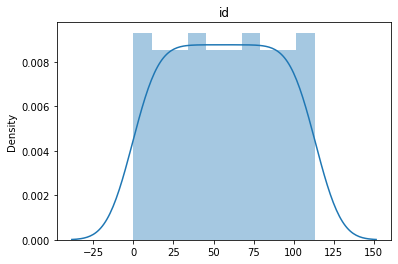

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


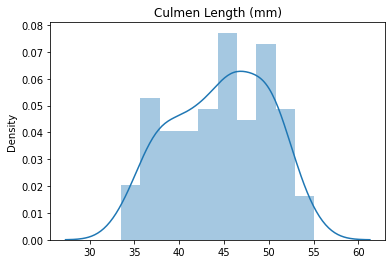

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


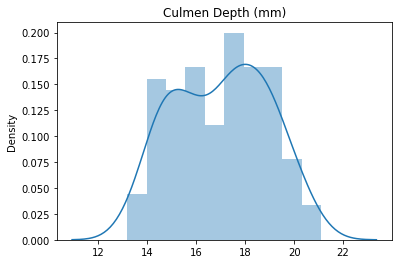

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


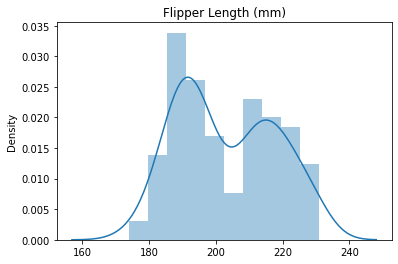

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


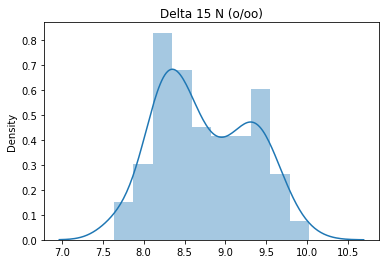

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


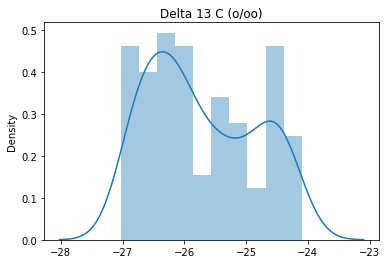

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


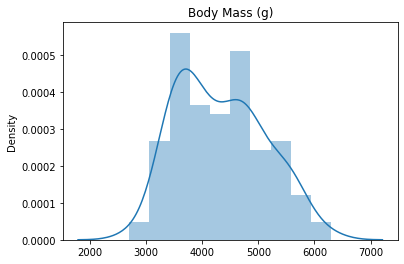

In [113]:
EDA_int(train)

#### 2) 범주형 변수 EDA

In [ ]:
def EDA_obj (data):
  colors = sns.color_palette("Blues")
  for i in data.columns:
    if data[i].dtypes == 'object':
      group_data = data.groupby([i],as_index=False).count()
      sns.barplot(x =i,y = 'Body Mass (g)',data = group_data ,palette='Blues')
      plt.title('%s barplot'%i)
      plt.xticks(rotation=45)
      plt.show()

      plt.pie(group_data['Body Mass (g)']/100, labels=group_data[i], autopct='%.1f%%', colors = colors)
      plt.title('%s pie plot'%i)
      plt.show()

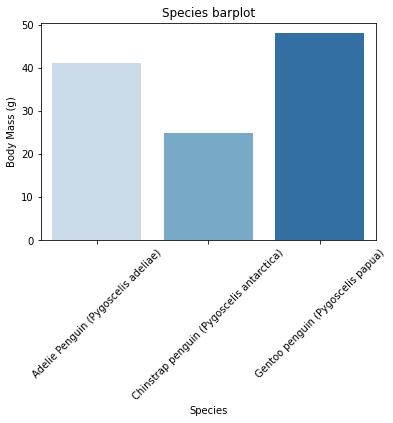

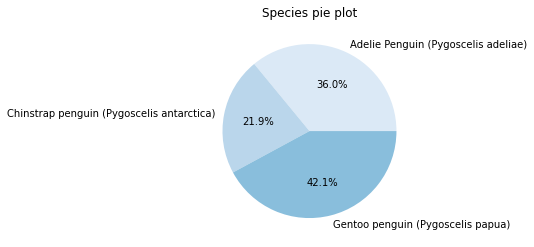

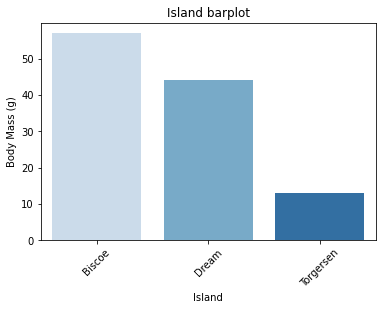

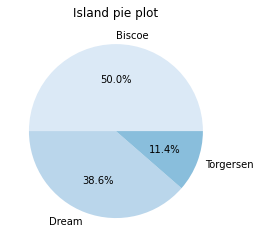

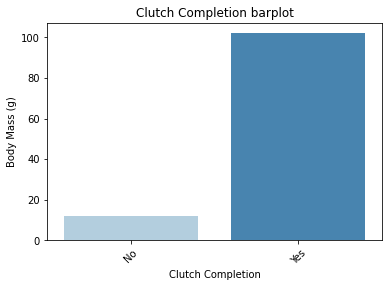

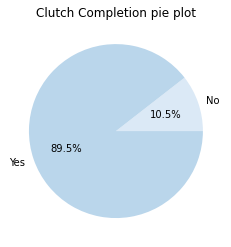

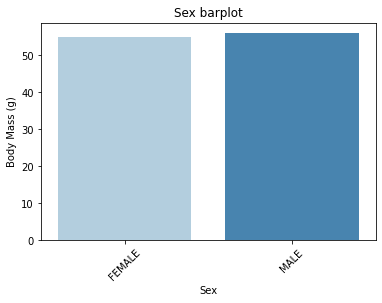

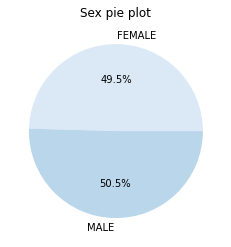

In [ ]:
EDA_obj(train)

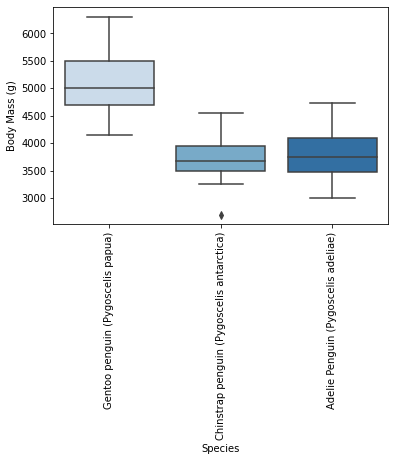

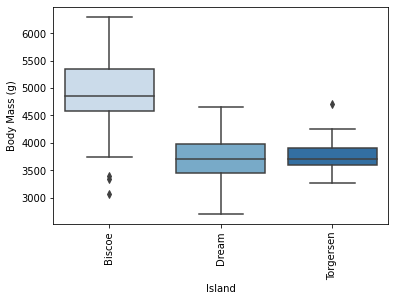

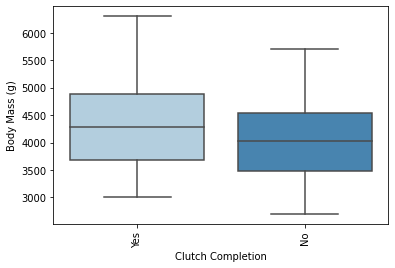

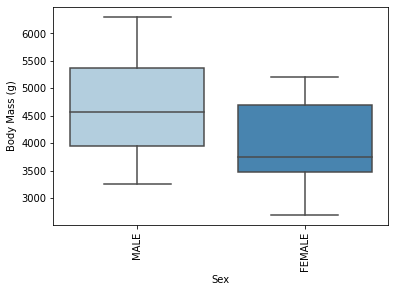

In [ ]:
for i in train.columns:
  if train[i].dtypes == 'object':
    sns.boxplot(x = i ,y='Body Mass (g)',data=train, palette='Blues')
    plt.xticks(rotation=90)
    plt.show()

#### 3) 변수 간 상관관계

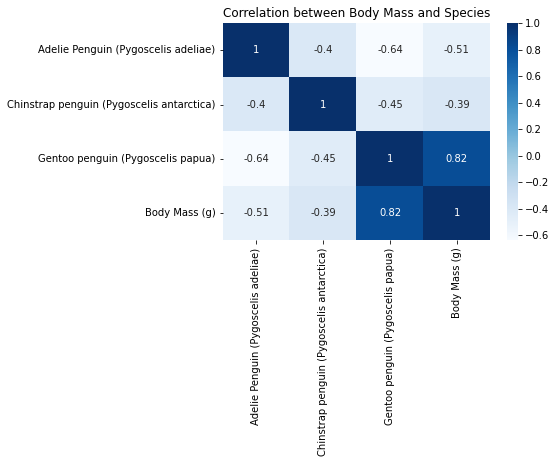

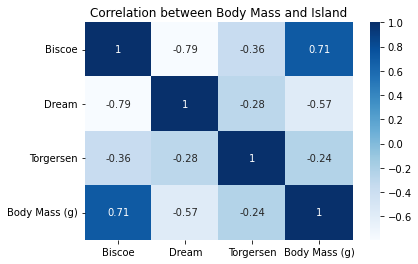

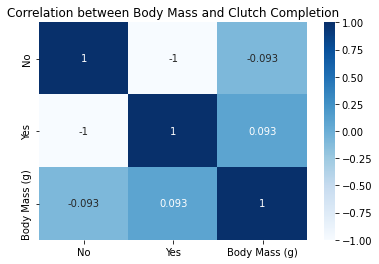

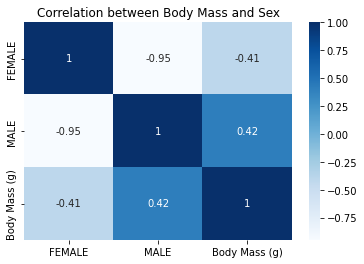

In [106]:
# 범주형 변수의 상관관계
for i in train.columns:
  if train[i].dtypes == 'object':
    Sp = pd.get_dummies(train[i])
    Sp['Body Mass (g)'] = train['Body Mass (g)'] 
    sns.heatmap(Sp.corr(),cmap='Blues',annot=True)
    plt.title('Correlation between Body Mass and %s'%i)
    plt.show()

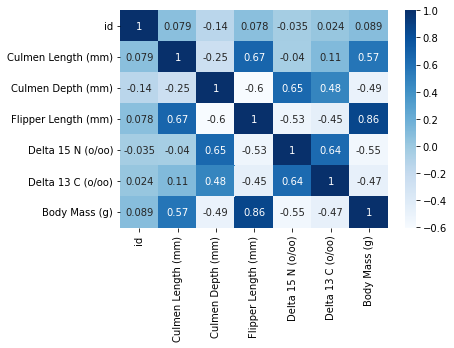

In [104]:
#수치형 변수 상관관계
sns.heatmap(train.corr(),cmap='Blues',annot=True)

범주형 변수와 Body Mass (g)
+ Species : 젠투 펭귄과 상관관계 존재
+ Island : Biscoe 섬과 상관관계 존재
+ Clutch Completion : 상관관계 존재하지 않음
+ Sex : 상관관계 존재하지 않음


수치형 변수와 Body Mass (g)
+ Flipper Length 상관관계 존재
+ Culmen Length 상관관계 존재

### 3.모델링